In [1]:
import numpy as np
import scipy 
from nimfa.methods import factorization
import nimfa
import cvxpy
import stft

# NMF

In [2]:
def factorization(V, rank=40, max_iter=80):
    """
    Produce non-negative factorization of matrix V:
    
    V = W.dot(H)
    
    """
    fctr = nimfa.Lsnmf(V, seed="nndsvd", rank=rank, max_iter=max_iter, sub_iter=30, inner_sub_iter=30)
    fctr.factorize()
    
    W = np.array(fctr.basis())
    H = np.array(fctr.coef())
    return W, H

In [25]:
def SNR(s_clean, s_noisy):
    """
    Singal-to-noise ratio:
    
    Arguments:
        s_clean: numpy.array: clean signal
        s_noisy: numpy.array: noisy signal
    
    Return:
        SNR: float: measure of the quality of denoiser
    Paper: Evaluation of Objective Quality 
    Measures for Speech Enhancement
    https://pdfs.semanticscholar.org/4974/18c70971c8d990e2edf989d6f05675b7c23a.pdf
    """
    from numpy.linalg import norm
    
    n = min(s_clean.shape[0], s_noisy.shape[0])
    s_clean, s_noisy = s_clean[: n], s_noisy[: n]
    SNR =  20 * np.log10(norm(s_clean) / norm(s_clean - s_noisy))
    
    return SNR

# Work with sounds

In [3]:
import sys
import StringIO
import base64
import struct

from scipy.io import wavfile
from scipy.signal import resample

from IPython.core.display import HTML
from IPython.core.display import display

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def load_wav(filename,samplerate=16000):
    
    # load file
    rate, data = wavfile.read(filename)

    # convert stereo to mono
    if len(data.shape) > 1:
        data = data[:,0]/2 + data[:,1]/2

    # re-interpolate samplerate    
    ratio = float(samplerate) / float(rate)
    data = resample(data, len(data) * ratio)
    
    return samplerate, data.astype(np.int16)

def wavPlayer(data, rate):
    """ will display html 5 player for compatible browser
    The browser need to know how to play wav through html5.
    there is no autoplay to prevent file playing when the browser opens
    Adapted from SciPy.io. and
    github.com/Carreau/posts/blob/master/07-the-sound-of-hydrogen.ipynb
    """
    
    buffer = StringIO.StringIO()
    buffer.write(b'RIFF')
    buffer.write(b'\x00\x00\x00\x00')
    buffer.write(b'WAVE')

    buffer.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    bits = data.dtype.itemsize * 8
    sbytes = rate*(bits // 8)*noc
    ba = noc * (bits // 8)
    buffer.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # data chunk
    buffer.write(b'data')
    buffer.write(struct.pack('<i', data.nbytes))

    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    buffer.write(data.tostring())
    # return buffer.getvalue()
    # Determine file size and place it in correct
    # position at start of the file.
    size = buffer.tell()
    buffer.seek(4)
    buffer.write(struct.pack('<i', size-8))
    
    val = buffer.getvalue()
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source controls src="data:audio/wav;base64,{base64}" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """.format(base64=base64.encodestring(val))
    display(HTML(src))

In [126]:
framelength = 512
hopsize = 128
window = scipy.signal.hamming

Clean

/home/vovacher/src/anaconda2/envs/denoising/lib/python2.7/site-packages/scipy/signal/signaltools.py:1889: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = zeros(newshape, 'D')


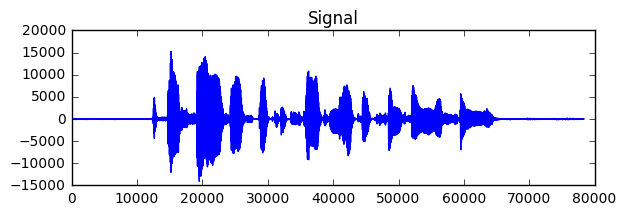

In [6]:
fs, s_clean = load_wav('../data/chime/clean/F01_22GC010A_BTH.CH1.wav')

plt.figure(figsize=(6.75,2))
plt.plot(s_clean)
plt.title('Signal')
plt.show()

wavPlayer(s_clean, fs)

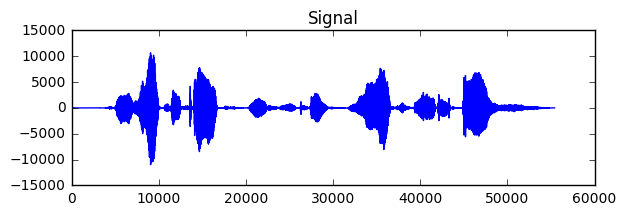

In [127]:
fs, s_clean = load_wav('../data/lubimov/speech_8khz.wav')

plt.figure(figsize=(6.75,2))
plt.plot(s_clean)
plt.title('Signal')
plt.show()

wavPlayer(s_clean, fs)

In [7]:
# f_clean, t_clean, Sxx_clean = scipy.signal.spectrogram(s_clean, fs=16000, nfft=1024)

In [115]:
S_clean = stft.spectrogram(s_clean, framelength, hopsize, window=window)
S_clean = np.array(S_clean)

In [116]:
V_clean = np.abs(S_clean)

Noisy

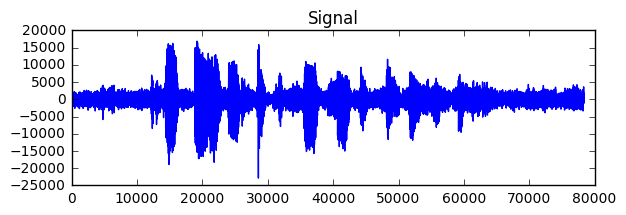

In [10]:
fs, s_speech= load_wav('../data/chime/noisy/caf_simu/F01_22GC010A_CAF.CH1.wav')

plt.figure(figsize=(6.75,2))
plt.plot(s_speech)
plt.title('Signal')
plt.show()

wavPlayer(s_speech, fs)

In [11]:
# f_noisy, t_noisy, Sxx_noisy = scipy.signal.spectrogram(s_noisy, fs=16000, nfft=1024)

In [117]:
S_speech = stft.spectrogram(s_speech, framelength, hopsize, window=window)
S_speech = np.array(S_speech)

In [118]:
V_speech = np.abs(S_speech)

# SNR testing:

In [114]:
fs, s_clean = load_wav('../data/lubimov/speech_8khz.wav')
fs, s_speech = load_wav('../data/lubimov/speech+noise_8khz.wav')

In [111]:
n = min(s_cl.shape[0], s_no.shape[0])
s_cl, s_no = s_cl[: n], s_no[: n]

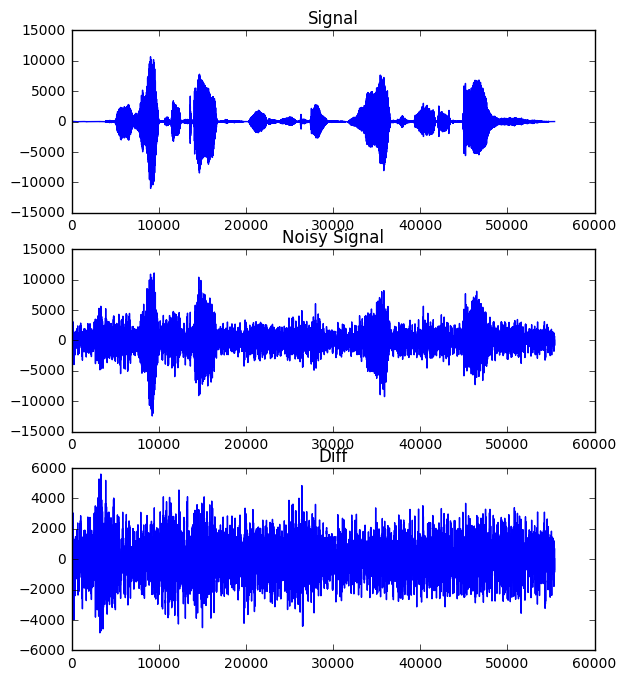

In [113]:
plt.figure(figsize=(6.75, 8))
plt.subplot(311)
plt.plot(s_cl)
plt.title('Signal')

plt.subplot(312)
plt.plot(s_no)
plt.title('Noisy Signal')

plt.subplot(313)
plt.plot(s_no - s_cl)
plt.title('Diff')

plt.show()

wavPlayer(s_cl, fs)
wavPlayer(s_no, fs)
wavPlayer(s_no - s_cl, fs)

In [93]:
n = min(s_cl.shape[0], s_no.shape[0])
s_cl, s_no = s_cl[: n], s_no[: n]
np.linalg.norm(s_cl) / np.linalg.norm(s_cl - s_no)

1.0000886812688239

In [94]:
np.linalg.norm(s_cl - s_no)

268929.75094436837

In [96]:
np.linalg.norm(s_no)

377732.01575852686

In [95]:
np.linalg.norm(s_cl)

268953.5999759066

In [67]:
n = min(s_cl.shape[0], s_no.shape[0])
s_cl, s_no = s_cl[: n], s_no[: n]
np.linalg.norm(s_cl) / np.linalg.norm(s_cl - s_no)

1.0000886812688239

In [97]:
SNR(s_cl, s_no)

0.00077024156147313953

In [98]:
_, s_cl = load_wav('../data/lubimov/speech_8khz.wav')
_, s_no = load_wav('../data/lubimov/denoised_8khz_SS_denseNMF.wav')

In [99]:
SNR(s_cl, s_no)

8.2461150368206493

In [35]:
_, s_cl = load_wav('../data/lubimov/speech_8khz.wav')
_, s_no = load_wav('../data/lubimov/denoised_8khz_SS_NMF.wav')

In [36]:
SNR(s_cl, s_no)

3.1692698565105304

In [37]:
_, s_cl = load_wav('../data/lubimov/speech+noise_44khz.wav')
_, s_no = load_wav('../data/lubimov/speech+noise_44khz_DENOISED.wav')

In [38]:
SNR(s_cl, s_no)

15.853480765213224

In [50]:
n = min(s_cl.shape[0], s_no.shape[0])
s_cl, s_no = s_cl[: n], s_no[: n]
np.linalg.norm(s_cl) / np.linalg.norm(s_cl - s_no)

6.2040321292845535

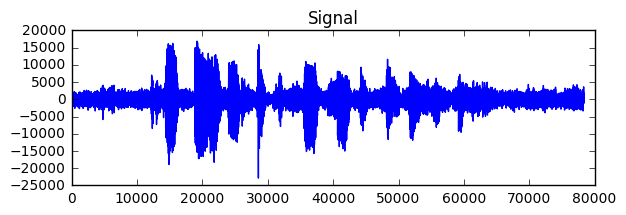

In [63]:
plt.figure(figsize=(6.75,2))
plt.plot(s_speech)
plt.title('Signal')
plt.show()

wavPlayer(s_speech, fs)

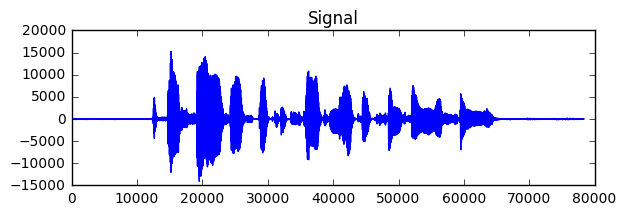

In [64]:
plt.figure(figsize=(6.75,2))
plt.plot(s_clean)
plt.title('Signal')
plt.show()

wavPlayer(s_clean, fs)

### MARKET SUMMER:

In [105]:
np.linalg.norm(s_clean)

473992.51258326857

In [102]:
np.linalg.norm(s_speech)

699051.79336441157

In [106]:
np.linalg.norm(s_speech - s_clean)

879417.68247005355

In [104]:
s_clean.shape[0]

78333

In [45]:
s_speech.shape[0]

78333

In [47]:
np.linalg.norm(s_clean) / np.linalg.norm(s_clean - s_speech)

0.5389845144481834

In [40]:
SNR(s_clean, s_speech)

-5.3684742467778168

Background

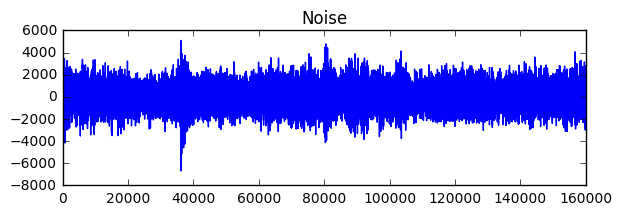

In [120]:
fs, s_noise = load_wav('../data/lubimov/noise_8khz.wav')

plt.figure(figsize=(6.75,2))
plt.plot(s_noise)
plt.title('Noise')
plt.show()

wavPlayer(s_noise, fs)

In [15]:
# f_background, t_background, Sxx_background = scipy.signal.spectrogram(s_background, fs=16000, nfft=1024)

In [121]:
S_noise = stft.spectrogram(s_noise, framelength, hopsize, window=window)
S_noise = np.array(S_noise)

In [122]:
V_noise = np.abs(S_noise)

Plotting

NameError: name 't_clean' is not defined

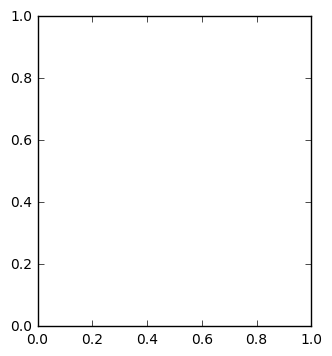

In [123]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.pcolormesh(t_clean, f_clean[:150], Sxx_clean[:150], cmap="Greys", 
               vmin=0, vmax=40000)
plt.title("Clean")
plt.subplot(132)
plt.pcolormesh(t_noisy, f_noisy[:150], Sxx_noisy[:150], cmap="Greys", 
               vmin=0, vmax=40000)
plt.title("Noisy")
plt.subplot(133)
plt.pcolormesh(t_background[:len(t_clean)], 
               f_background[:150], 
               Sxx_background[:150, :len(t_clean)], cmap="Greys", 
               vmin=0, vmax=40000)
plt.title("Background")

In [124]:
W_clean, H_clean = factorization(V_clean)

In [125]:
plt.plot(f_clean, W_clean.T[0])
plt.title("W")

NameError: name 'f_clean' is not defined

In [124]:
W_noise, H_noise = factorization(V_noise)

In [ ]:
plt.plot(f_background, W_background.T[0])
plt.title("W")

In [ ]:
import cvxpy
from nimfa.methods.seeding.nndsvd

In [125]:
def projection(V, W, max_iter=30, callback=None):
    
#     W, H = Nndsvd().initialize(A, rank=rank, options={'flag': 0})
    
    m = V.shape[0]
    n = V.shape[1]
    rank = W.shape[1]

    H = cvxpy.Variable(rank, n)
    constraints = [H >= 0]

    objective = cvxpy.Minimize(cvxpy.norm(V - W * H, 'fro'))

    prob = cvxpy.Problem(objective, constraints)
    prob.solve(solver=cvxpy.SCS)
    
    return np.array(H.value)

In [126]:
W_basis = np.hstack((W_clean, W_noise))

In [127]:
H_basis = projection(np.array(V_speech), np.array(W_basis))

In [128]:
H_reconstructed = H_basis[:40]

In [129]:
V_reconstructed = W_clean.dot(H_reconstructed)

In [130]:
s_naive = stft.ispectrogram(V_reconstructed, framelength, hopsize, window=window)

In [132]:
s_smart = overlap_add_reconstruction(V_reconstructed, S_speech, len(s_clean), framelength, hopsize, window, 40)

In [141]:
s_wiener = stft.ispectrogram(S_speech * V_reconstructed / (V_reconstructed + W_noise.dot(H_basis[40:])), 
                             framelength, 
                             hopsize, 
                             window=window)

NameError: name 's_smart' is not defined

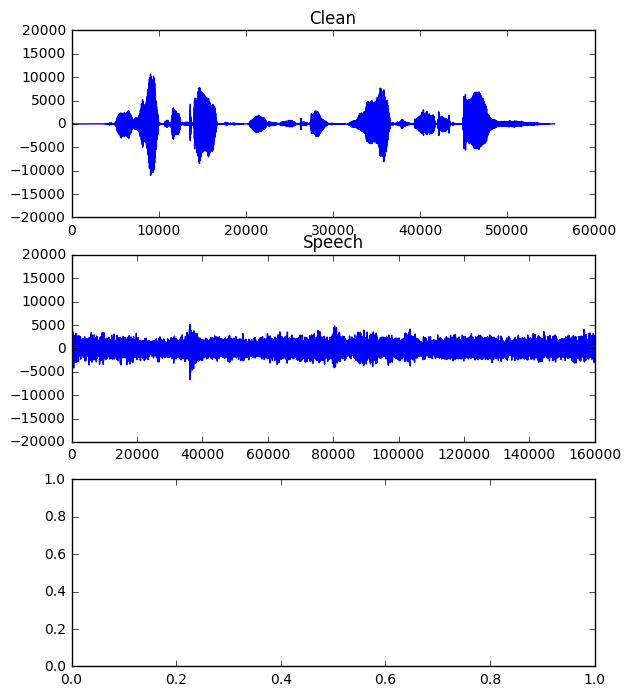

In [134]:
plt.figure(figsize=(6.75,14))

plt.subplot(511)
plt.plot(s_clean)
plt.ylim([-20000, 20000])
plt.title('Clean')
plt.subplot(512)
plt.plot(s_speech)
plt.ylim([-20000, 20000])
plt.title('Speech')
plt.subplot(513)
plt.plot(s_smart[-1] * 1.4)
plt.ylim([-20000, 20000])
plt.title('Smart Reconstructed')
plt.subplot(514)
plt.plot(s_naive)
plt.ylim([-20000, 20000])
plt.title('Naive Reconstructed')
plt.subplot(515)
plt.plot(s_wiener)
plt.ylim([-20000, 20000])
plt.title('Wiener Reconstructed')
plt.show()

wavPlayer(np.array(s_speech, dtype=np.int16), fs)
wavPlayer(np.array(s_naive, dtype=np.int16), fs)
wavPlayer(np.array(s_smart[-1], dtype=np.int16), fs)
wavPlayer(np.array(s_wiener, dtype=np.int16), fs)

In [51]:
plt.plot(np.linalg.norm(s_smart - s_clean))

ValueError: operands could not be broadcast together with shapes (11,) (78333,) 

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.pcolormesh(t_clean, f_clean[:150], Sxx_clean[:150], cmap="Greys", 
               vmin=0, vmax=40000)
plt.title("Clean")
plt.subplot(132)
plt.pcolormesh(t_noisy, f_noisy[:150], Sxx_noisy[:150], cmap="Greys", 
               vmin=0, vmax=40000)
plt.title("Noisy")
plt.subplot(133)
plt.pcolormesh(t_clean, f_clean[:150], V_reconstructed[:150], cmap="Greys", 
               vmin=0, vmax=40000)
plt.title("Reconstructed")

In [ ]:
np.linalg.norm(Sxx_clean - Sxx_noisy) / np.linalg.norm(Sxx_clean)

In [ ]:
x = scipy.zeros(len(s_clean))
framesamp = V_reconstructed.shape[1]
hopsamp = int(32)

In [ ]:
f_clean, t_clean, Sxx_clean = scipy.signal.spectrogram(s_clean, fs=16000, nperseg=256, noverlap=32)

In [ ]:
def stft(x, frame_size, hop):
#     w = scipy.hanning(framesamp)
    w = scipy.signal.windows.tukey(frame_size, 0.25)
    X = np.array([np.fft.rfft(w * x[i : i + frame_size]) 
                  for i in range(0, len(x) - frame_size, hop)])
    return X.T

In [ ]:
Sxx_clean_my = stft(s_clean, 256, 128)

In [ ]:
def istft(X, T, hop):
    x = scipy.zeros(T)
    framesamp = X.shape[1]
    hopsamp = int(hop)
    for n,i in enumerate(range(0, len(x)-framesamp, hopsamp)):
        x[i:i+framesamp] += scipy.real(scipy.ifft(X[n]))
    return x

In [ ]:
def istft(X, duration, hop):
    x = scipy.zeros(duration)
    frame_size = X.shape[1]
    for n, i in enumerate(range(0, len(x) - frame_size, hop)):
        x[i : i + frame_size] += np.fft.irfft(X[n])
    return x

In [ ]:
import stft

In [ ]:
framelength = 256
hopsize = 128

In [ ]:
sxx_lib = stft.spectrogram(s_clean, framelength, hopsize)

In [ ]:
sxx_lib_magnitude = np.abs(sxx_lib)

In [ ]:
s_clean - stft.ispectrogram(sxx_lib, framelength, hopsize)

In [ ]:
sxx_recon_lib = stft.ispectrogram(sxx_lib, framelength, hopsize)

In [58]:
def naive_reconstruction(V, S):
    angles = np.angle(S)
    return V * np.cos(angles) + np.complex(0, 1) * V * np.sin(angles)

In [131]:
def overlap_add_reconstruction(V, S, signal_length, framelength, hop, window, max_iter=10):
    xk = np.random.random(signal_length) * 100
#     xk = np.zeros(signal_length)
#     xk = stft.ispectrogram(naive_reconstruction(V, S), framelength, hop, window=window)
    xks = [xk]
    for i in range(max_iter):
        X = stft.spectrogram(xk, framelength, hop)
        Z = V * np.exp(np.complex(0, 1) * np.angle(X))
        xk = stft.ispectrogram(Z, framelength, hop)
        xks.append(xk)
    return xks

In [ ]:
hist = overlap_add_reconstruction(sxx_lib_magnitude, sxx_lib, len(s_clean), framelength, hopsize, 40)

In [ ]:
naive = stft.ispectrogram(sxx_lib_magnitude)

In [ ]:
wavPlayer(np.array(hist[-1], dtype=np.int16), fs)
wavPlayer(np.array(naive, dtype=np.int16), fs)

In [ ]:
plt.plot([np.linalg.norm(s_clean - hist[i]) for i in range(len(hist))])

In [ ]:
plt.figure(figsize=(6.75,10))
plt.subplot(311)
plt.plot(s_clean)
plt.title('Signal')
plt.subplot(312)
plt.plot(hist[-1])
plt.title('Iter')
plt.subplot(313)
plt.plot(naive)
plt.title('Iter')
plt.show()

In [ ]:
len(s_clean)

In [ ]:
Sxx_clean_my.shape

In [ ]:
sxx_lib.shape

In [ ]:
s_reconstructed = istft(Sxx_clean_my, len(s_clean), 128)

In [ ]:
s_recon = istft(V_reconstructed, fs, len(s_clean), hop=224)

In [ ]:
plt.figure(figsize=(6.75,2))
plt.plot(s_recon)
plt.title('Signal')
plt.show()

In [ ]:
wavPlayer(s_recon, fs)

In [ ]:
np.array(W.dot(H)).shape

In [ ]:
f_factor, t_factor, Sxx_factor = f_noisy, t_noisy, np.array(W.dot(H))

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.pcolormesh(t_noisy, f_noisy[:150] / (len(s_noisy) * 1. / fs), Sxx_noisy[:150], cmap="Greys", vmax=40000)
plt.title("Noisy")
plt.subplot(122)
plt.pcolormesh(t_factor, f_factor[:150] / (len(s_noisy) * 1. / fs), Sxx_factor[:150], cmap="Greys", vmax=40000)
plt.title("Factorized")

In [ ]:
W, H = factorization(Sxx_clean)

In [ ]:
note = 1
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(f_clean / (len(s_clean) * 1. / fs), W.T[note])
plt.title("W")
plt.subplot(122)
plt.plot(t_clean, H[note])
plt.title("H")

In [ ]:
plt.pcolormesh(t_clean, f_clean[:150] / (len(s_clean) * 1. / fs), Sxx_clean[:150], cmap="Greys", vmax=40000)
main_freq = (f_clean[:150] / (len(s_clean) * 1. / fs))[np.argmax(W.T[note])]
plt.plot([0, 5], [main_freq, main_freq], "r")
plt.xlim([0, 5])
plt.title("Clean")

# Piano

In [ ]:
import os

In [ ]:
s = np.array([0], dtype=np.int16)
for filename in os.listdir("../data/piano")[:5] * 2:
    fs, note = load_wav(os.path.join("../data/piano/", filename))
#     note += (np.random.random(note.shape) * np.max(note) * 0.5).astype(np.int16)
    s = np.append(s, note)
s = s[1:]

In [ ]:
plt.figure(figsize=(6.75,2))
plt.plot(s)
plt.title('Signal')
plt.show()

wavPlayer(s, fs)

In [ ]:
f, t, Sxx = scipy.signal.spectrogram(s, fs=16000, nfft=1024)

In [ ]:
plt.specgram(s, Fs=16000, NFFT=1024)
plt.show()

In [ ]:
W, H = factorization(Sxx, 5)

In [ ]:
note = 4
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(f / (len(s) * 1. / fs), W.T[note])
plt.title("W")
plt.subplot(122)
plt.plot(t, H[note])
plt.title("H")